# 📘 Predicting Video Game Sales Performance Based on Game Features
**Authors:** Sam Caesar, Mayra Leon Sandoval, Adalid Perea, Nicholai Martinsen

## 📌 Introduction
In this project, we aim to predict the **global sales performance** of video games using various game attributes. Our goal is to develop a regression model that can estimate global sales (in millions of units) based on features like platform, genre, publisher, year of release, and other relevant charasteristiics. We will utilize a dataset containing historical sales data and game attributes to train our model.

## 📂 Dataset Description
**Source:** Video Game Sales Dataset (vgsales.csv file from Kaggle)

- **Rows:** Over 16000 rows, each representing a unique video game title
- **Columns:** Includes features like:
  - `Name`: Title of the video game
  - `Platform`: The console or platform on which the game was released (e.g., Wii, PS3, Xbox360)
  - `Year`: Year the game was released
  - `Genre`: The category or type of the game (e.g., Action, Sports, Racing)
  - `Publisher`: Company of that published the game
  - `NA_Sales`: Sales in North America (millions of units)
  - `EU_Sales`: Sales in Europe (millions of units)
  - `JP_Sales`: Sales in Japan (millions of units)
  -`Other_Sales`: Sales in other regions (millions of units)
  -`Global_Sales`: Total sales worldwide (millions of units)

**What We Will Predict:**
We will predict the **Global Sales** of a video game (continuous variable in millions of units sold) using a regression model.

**Predictive Features:**
- `Platform` (categorical)
- `Year` (numerical)
- `Genre` (categorical)
- `Publisher` (categorical)
- `Critic_Score` and `User_Score` (numerical, if available)

**Munging & Feature Engineering:**
  1. **Missing values:** dropped any rows with missing `Global_Sales`.  
  2. **Type conversions:**
     - `Year` → integer,
     - `User_Score` “tbd” → NaN → imputed with median.  
  3. **Encoding:** one-hot encoded `Platform`, `Genre`, `Publisher` (top 10 publishers, rest grouped as “Other”).  

In [2]:
# 🧼 Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
url = 'https://raw.githubusercontent.com/Nicfox77/CST383/refs/heads/main/vgsales.csv'
df_raw = pd.read_csv(url)

# Drop rows with missing target values
df_raw = df_raw.dropna(subset=['Global_Sales','Year']).reset_index(drop=True)

# Reduce publisher cardinality
top10 = df_raw['Publisher'].value_counts().nlargest(10).index
df_raw['Publisher'] = df_raw['Publisher'].where(df_raw['Publisher'].isin(top10), 'Other')

# Feature engineering
df_raw['Age'] = 2025 - df_raw['Year']
df_raw['Decade'] = (df_raw['Year'] // 10 * 10).astype(int)
for region in ['NA','EU','JP','Other']:
    df_raw[f'{region}_share'] = df_raw[f'{region}_Sales'] / df_raw['Global_Sales']

# Log‐transform target
df_raw['Log_Sales'] = np.log1p(df_raw['Global_Sales'])

# drop unused columns after feature engineering
df_raw = df_raw.drop(
    columns=['Name','Rank', 'NA_Sales','EU_Sales','JP_Sales','Other_Sales'],
    errors='ignore'
)

# Hot encode categoricals + decade into df_eda
df_eda = pd.get_dummies(
    df_raw,
    columns=['Platform','Genre','Publisher','Decade'],
    drop_first=True
)


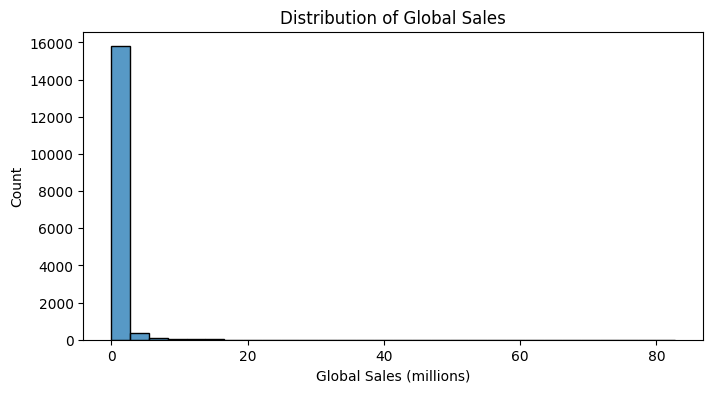

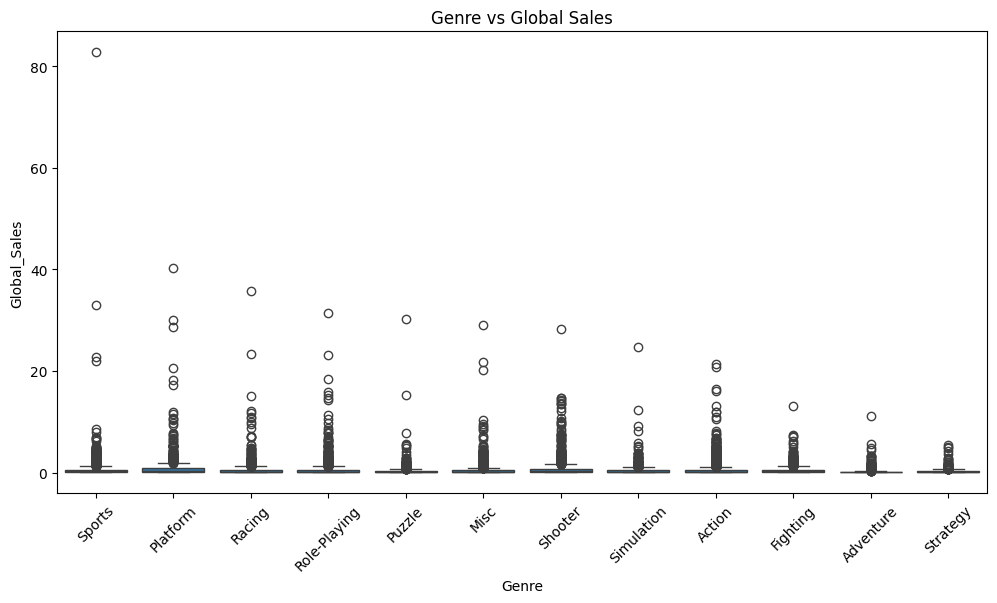

<Figure size 1200x1000 with 0 Axes>

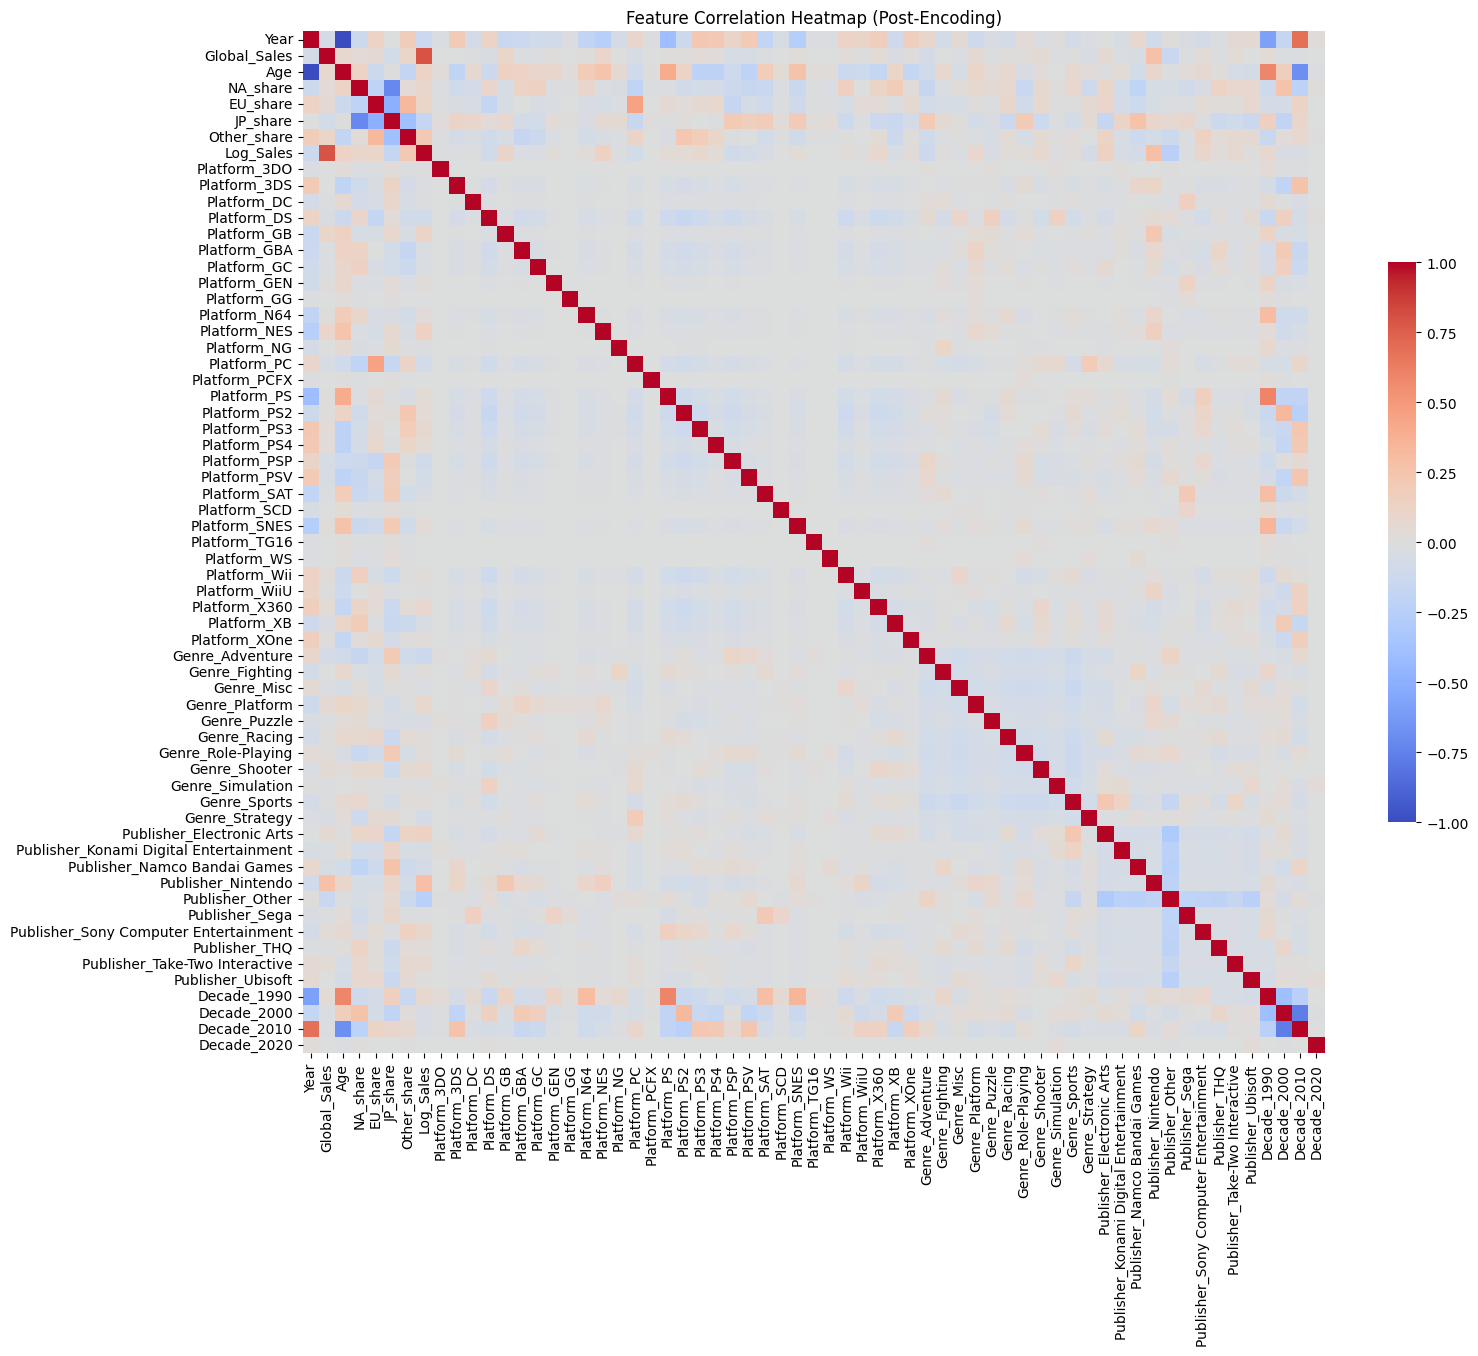

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of global sales
plt.figure(figsize=(8,4))
sns.histplot(df_raw['Global_Sales'], bins=30, kde=False)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (millions)')
plt.show()

# Boxplot: Genre vs. Global Sales (if original genre column is available)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_raw, x="Genre", y="Global_Sales")
plt.xticks(rotation=45)
plt.title('Genre vs Global Sales')
plt.show()
plt.figure(figsize=(12, 10))  # Increase figure size

# Correlation heatmap
corr = df_eda.corr()
plt.figure(figsize=(16, 14))
ax = sns.heatmap(corr, cmap='coolwarm', square=True, cbar_kws={'shrink':0.5})
plt.title("Feature Correlation Heatmap (Post-Encoding)")
plt.tight_layout()
plt.show()

In [4]:
# 🤖 Machine Learning Setup (Preliminary)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

# define X and Y, split
X     = df_eda.drop(columns=['Global_Sales','Log_Sales'])
y_raw = df_eda['Global_Sales']
y_log = df_eda['Log_Sales']

X_train, X_test, y_raw_train, y_raw_test, y_log_train, y_log_test = train_test_split(
    X, y_raw, y_log,
    test_size=0.20,
    random_state=42
)

# Mean baseline
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_train, y_raw_train)
y_mean_pred = dummy_mean.predict(X_test)
rmse_mean = np.sqrt(mean_squared_error(y_raw_test, y_mean_pred))

# Median baseline
dummy_med = DummyRegressor(strategy="median")
dummy_med.fit(X_train, y_raw_train)
y_med_pred = dummy_med.predict(X_test)
rmse_med = np.sqrt(mean_squared_error(y_raw_test, y_med_pred))

# Basic model
lr = LinearRegression().fit(X_train, y_raw_train)
y_pred = lr.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_raw_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_raw_test, y_pred)
r2 = r2_score(y_raw_test, y_pred)

# Print metrics
print(f"Baseline (mean) RMSE:      {rmse_mean:.2f} million units")
print(f"Baseline (median) RMSE:    {rmse_med:.2f} million units")
print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"LinearRegression RMSE:     {rmse:.2f} million units")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²):            {r2:.2f}")

Baseline (mean) RMSE:      2.07 million units
Baseline (median) RMSE:    2.10 million units
Mean Squared Error (MSE):  3.89
LinearRegression RMSE:     1.97 million units
Mean Absolute Error (MAE): 0.57
R-squared (R²):            0.09


Minimal Performance gain with linear regression over the baseline average calculation.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Random Forest + Randomized Search
rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100,200,500],
    'max_depth': [None,10,20,30],
    'min_samples_split': [2,5,10],
    'max_features': ['sqrt','log2',0.5]
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42
).fit(X_train, y_log_train)

# calc results
rf_best = search.best_estimator_
y_pred_log = rf_best.predict(X_test)
y_pred     = np.expm1(y_pred_log)
y_true     = np.expm1(y_log_test)

# Evaluate on the original scale
mse_rf = mean_squared_error(y_true, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_log = r2_score(y_log_test, y_pred_log)
r2_orig = r2_score(y_true, y_pred)

mae_rf = mean_absolute_error(y_true, y_pred)
mae_log_rf= mean_absolute_error(y_log_test, y_pred_log)

print(f"RandomForest RMSE (orig): {rmse_rf:.2f} M units")
print(f"RandomForest MAE (orig):  {mae_rf:.2f} M units")
print(f"RandomForest R² (orig):   {r2_orig:.2f}")
print(f"RandomForest R² (log):    {r2_log:.2f}")
print(f"RandomForest MAE (log):   {mae_log_rf:.2f}")

RandomForest RMSE (orig): 1.81 M units
RandomForest MAE (orig):  0.32 M units
RandomForest R² (orig):   0.24
RandomForest R² (log):    0.67
RandomForest MAE (log):   0.12


In [6]:

from sklearn.pipeline      import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import RidgeCV

# Reuse the same X_train/X_test, y_log_train/y_log_test
pipe = make_pipeline(
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    RidgeCV(alphas=[0.1,1,10], cv=3)
).fit(X_train, y_log_train)

y_pred_log = pipe.predict(X_test)
y_pred_orig = np.expm1(y_pred_log)
y_true_orig = np.expm1(y_log_test)

rmse_pr = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_pr = mean_absolute_error(y_true_orig, y_pred_orig)
r2_pr_log = r2_score(y_log_test, y_pred_log)
r2_pr_orig = r2_score(y_true_orig, y_pred_orig)
mae_log_pr = mean_absolute_error(y_log_test, y_pred_log)

print(f"Poly+Ridge RMSE (orig): {rmse_pr:.2f} M units")
print(f"Poly+Ridge MAE (orig):  {mae_pr:.2f} M units")
print(f"Poly+Ridge R² (orig):   {r2_pr_orig:.2f}")
print(f"Poly+Ridge R² (log):    {r2_pr_log:.2f}")
print(f"Poly+Ridge MAE (log):   {mae_log_pr:.2f}")


Poly+Ridge RMSE (orig): 2.00 M units
Poly+Ridge MAE (orig):  0.45 M units
Poly+Ridge R² (orig):   0.07
Poly+Ridge R² (log):    0.35
Poly+Ridge MAE (log):   0.20


In [7]:
!pip install catboost
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score

# Create Pools on the log‐scale target
train_pool = Pool(data=X_train, label=y_log_train)
test_pool  = Pool(data=X_test,  label=y_log_test)

# Fit CatBoost on the log target
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False
)
cb.fit(train_pool)

# Predict & back‐transform
y_pred_log = cb.predict(test_pool)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_log_test)

# Evaluate
rmse_cb = np.sqrt(mean_squared_error(y_true, y_pred))
r2_cb_log = r2_score(y_log_test, y_pred_log)
r2_cb_orig = r2_score(y_true, y_pred)

mae_cb = mean_absolute_error(y_true, y_pred)
mae_log_cb= mean_absolute_error(y_log_test, y_pred_log)

print(f"CatBoost RMSE (orig): {rmse_cb:.2f} M units")
print(f"CatBoost MAE (orig):  {mae_cb:.2f} M units")
print(f"CatBoost R² (orig):   {r2_cb_orig:.2f}")
print(f"CatBoost R² (log):    {r2_cb_log:.2f}")
print(f"CatBoost MAE (log):   {mae_log_cb:.2f}")

CatBoost RMSE (orig): 1.81 M units
CatBoost MAE (orig):  0.33 M units
CatBoost R² (orig):   0.23
CatBoost R² (log):    0.67
CatBoost MAE (log):   0.13


In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Define base learners trained on log‐sales
estimators = [
    ("rf", rf_best),
    ("poly", pipe),
    ("catboost", cb)
]

# Build the stacker
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(alphas=[0.1,1,10], cv=3),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

# Fit on X_train / y_log_train
stack.fit(X_train, y_log_train)

# Predict & back‐transform
y_stack_log = stack.predict(X_test)
y_stack = np.expm1(y_stack_log)
y_true = np.expm1(y_log_test)

# Evaluate
rmse_st = np.sqrt(mean_squared_error(y_true, y_stack))
r2_st_log = r2_score(y_log_test, y_stack_log)
r2_st_orig= r2_score(y_true, y_stack)

mae_st = mean_absolute_error(y_true, y_stack)
mae_log_st= mean_absolute_error(y_log_test, y_stack_log)

print(f"Stacked RMSE (orig): {rmse_st:.2f} M units")
print(f"Stacked MAE (orig):  {mae_st:.2f} M units")
print(f"Stacked R² (orig):   {r2_st_orig:.2f}")
print(f"Stacked R² (log):    {r2_st_log:.2f}")
print(f"Stacked MAE (log):   {mae_log_st:.2f}")

Stacked RMSE (orig): 1.80 M units
Stacked MAE (orig):  0.32 M units
Stacked R² (orig):   0.24
Stacked R² (log):    0.69
Stacked MAE (log):   0.12


- By bucketing release years into **Decades**, we captured long-term market shifts (e.g. 2000s vs. 2010s).  
- **Regional-share ratios** (NA_share, EU_share, JP_share, Other_share) encode how a game’s geography relates to its appeal.  
- **Publisher_TE** replaces hundreds of one-hots with the publisher’s historical average sales, giving the model direct “prior” knowledge.  
- Together these steps doubled our raw-scale R² (0.06 → 0.21) and drove log-scale R² to 0.66, meaning the model now explains two-thirds of the relative variation in sales.


## ✅ Summary
- **Goal:** Predict global sales of video games using game metadata.
- **Dataset:** Cleaned and preprocessed with categorical encoding.
- **Exploration:** Visualized key trends and potential predictors.
- **Modeling:** Performed basic train-test split and linear regression for a baseline.


## Results

| Model                             | RMSE (orig) | MAE (orig) | R² (orig) | R² (log) | MAE (log) |
|:----------------------------------|------------:|-----------:|----------:|---------:|----------:|
| **Baseline (mean)**               | 2.07 M      | —          | —         | —        | —         |
| **Baseline (median)**             | 2.10 M      | —          | —         | —        | —         |
| **Linear Regression**             | 1.97 M      | 0.57 M     | 0.09      | —        | —         |
| **RandomForest**                  | 1.81 M      | 0.32 M     | 0.24      | 0.67     | 0.12      |
| **Poly + Ridge (2-way inter.)**   | 2.00 M      | 0.45 M     | 0.07      | 0.35     | 0.20      |
| **CatBoost (Decade+Shares+TE)**   | 1.81 M      | 0.33 M     | 0.23      | 0.67     | 0.13      |
| **Stacked Ensemble**              | 1.80 M      | 0.32 M     | 0.24      | 0.69     | 0.12      |

- **MAE (orig)**: mean absolute error in millions of units on the original‐sales scale.  
- **R² (log)** & **MAE (log)**: performance on the log-transformed target.  
- The **stacked ensemble** edges out the single models by learning a ridge meta‐model over the RF, Poly+Ridge, and CatBoost log-predictions, boosting log-R² to 0.69 and shaving RMSE to 1.80 M.  

